In [31]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from TINTOlib.igtd import IGTD
from kan import *
from tqdm import tqdm


import traceback
import time
import gc
import copy
import traceback
import cv2
import math
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim


if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [3]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# BEST 3.23

In [4]:
folder="data/puma8NH"
x_col=["theta1", "theta2", "theta3", "thetad1", "thetad2", "thetad3", "tau1","tau2"]
target_col=["target"]

# Functions

### Load Dataset and Images

In [5]:
def load_and_clean(npy_filename, y_filename, x_col, target_col):
    """
    Load the feature array (npy_filename) and label array (y_filename),
    drop rows in the feature array that contain any NaNs, and apply
    the same mask to the label array.
    """
    # Load numpy arrays
    X = np.load(os.path.join(folder, npy_filename))
    y = np.load(os.path.join(folder, y_filename))
    
    # Ensure the number of rows matches between X and y
    if X.shape[0] != y.shape[0]:
        raise ValueError("The number of rows in {} and {} do not match.".format(npy_filename, y_filename))
    
    # Create a boolean mask for rows that do NOT have any NaN values in X
    valid_rows = ~np.isnan(X).any(axis=1)
    #print(valid_rows)
    # Filter both arrays using the valid_rows mask
    X_clean = X[valid_rows]
    y_clean = y[valid_rows]
    
    # Convert arrays to DataFrames
    df_X = pd.DataFrame(X_clean)
    df_y = pd.DataFrame(y_clean)
    df_X.columns = x_col
    df_y.columns = target_col
    return df_X, df_y

In [6]:
def load_and_preprocess_data(X_train, y_train, X_test, y_test, X_val, y_val, image_model, problem_type, batch_size=32):
    # Add target column to input for IGTD
    X_train_full = X_train.copy()
    X_train_full["target"] = y_train.values

    X_val_full = X_val.copy()
    X_val_full["target"] = y_val.values

    X_test_full = X_test.copy()
    X_test_full["target"] = y_test.values

    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        image_model.fit_transform(X_train_full, f'{images_folder}/train')
        image_model.saveHyperparameters(f'{images_folder}/model.pkl')
    else:
        print("The images are already generated")

    # Load image paths
    imgs_train = pd.read_csv(os.path.join(f'{images_folder}/train', f'{problem_type}.csv'))
    imgs_train["images"] = images_folder + "/train/" + imgs_train["images"]

    if not os.path.exists(f'{images_folder}/val'):
        image_model.transform(X_val_full, f'{images_folder}/val')
    else:
        print("The images are already generated")

    imgs_val = pd.read_csv(os.path.join(f'{images_folder}/val', f'{problem_type}.csv'))
    imgs_val["images"] = images_folder + "/val/" + imgs_val["images"]

    if not os.path.exists(f'{images_folder}/test'):
        image_model.transform(X_test_full, f'{images_folder}/test')
    else:
        print("The images are already generated")

    imgs_test = pd.read_csv(os.path.join(f'{images_folder}/test', f'{problem_type}.csv'))
    imgs_test["images"] = images_folder + "/test/" + imgs_test["images"]

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in imgs_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in imgs_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in imgs_test["images"]])

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)

    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape

In [7]:
def complete_coordinate_and_xcol(coordinate, x_col):
    """
    Given a coordinate (tuple of row, col arrays) and x_col feature list,
    return completed coordinate and x_col including empty positions.

    Empty positions are filled with labels: 'Ex1', 'Ex2', ...
    """

    row_coords, col_coords = coordinate
    max_row = row_coords.max()
    max_col = col_coords.max()
    
    # All possible coordinate slots
    full_coords = set((r, c) for r in range(max_row + 1) for c in range(max_col + 1))
    current_coords = set(zip(row_coords, col_coords))
    missing_coords = sorted(full_coords - current_coords)

    # Create updated coordinate arrays
    new_row_coords = list(row_coords)
    new_col_coords = list(col_coords)
    new_x_col = list(x_col)

    for idx, (r, c) in enumerate(missing_coords):
        new_row_coords.append(r)
        new_col_coords.append(c)
        new_x_col.append(f"Ex{idx+1}")

    completed_coordinate = (np.array(new_row_coords), np.array(new_col_coords))
    return completed_coordinate, new_x_col

In [8]:
def plot_feature_mapping(x_col, coordinate, scale=(4,4)):
    grid = np.full(scale, "", dtype=object)
    rows, cols = coordinate
    for i, (r, c) in enumerate(zip(rows, cols)):
        if i < len(x_col):
            grid[r, c] = x_col[i]
        else:
            grid[r, c] = "?"
    
    plt.figure(figsize=(scale[1] * 2, scale[0] * 2))
    for i in range(scale[0]):
        for j in range(scale[1]):
            plt.text(j, i, grid[i, j], ha='center', va='center', fontsize=10,
                     bbox=dict(facecolor='white', edgecolor='gray'))
    
    plt.xticks(np.arange(scale[1]))
    plt.yticks(np.arange(scale[0]))
    plt.grid(True)
    plt.title("Feature → Pixel Mapping")
    plt.gca().invert_yaxis()  # So row 0 is at the top
    plt.show()

In [9]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

### Functions for KAN

In [10]:
def average_rmse(output, val_target):
    """
    Computes the root mean squared error (RMSE) between output and val_target.

    Args:
        output (torch.Tensor): The predicted output tensor.
        val_target (torch.Tensor): The ground truth tensor.
    
    Returns:
        float: The RMSE value.
    """
    mse = torch.mean((output - val_target) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

In [11]:
def plot_training_RMSE(avg_rmse, train_loss, val_loss):
    print(avg_rmse)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['train', 'val'])
    plt.ylabel('RMSE')
    plt.xlabel('step')
    plt.yscale('log')

In [12]:
def plot_sorted_feature_importance(columns, importances):
    # Move to CPU and numpy if it's a GPU tensor
    if isinstance(importances, torch.Tensor):
        importances = importances.detach().cpu().numpy()

    # Pair columns and importances and sort by importance descending
    sorted_pairs = sorted(zip(columns, importances), key=lambda x: x[1], reverse=True)
    sorted_columns, sorted_importances = zip(*sorted_pairs)

    # Create the bar plot
    plt.figure(figsize=(12, 6))
    plt.barh(sorted_columns, sorted_importances, color='royalblue')
    plt.xlabel('Importance')
    plt.title('Feature Importances (Sorted)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [13]:
def custom_fit(model, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., update_grid=True, 
               grid_update_num=10, loss_fn=None, lr=1.,start_grid_update_step=-1, stop_grid_update_step=50, batch=-1,
            metrics=None, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', 
               singularity_avoiding=False, y_th=1000., reg_metric='edge_forward_spline_n', display_metrics=None):
    '''
    training

    Args:
    -----
        dataset : dic
            contains dataset['train_input'], dataset['train_label'], dataset['val_input'], dataset['val_label']
        opt : str
            "LBFGS" or "Adam"
        steps : int
            training steps
        log : int
            logging frequency
        lamb : float
            overall penalty strength
        lamb_l1 : float
            l1 penalty strength
        lamb_entropy : float
            entropy penalty strength
        lamb_coef : float
            coefficient magnitude penalty strength
        lamb_coefdiff : float
            difference of nearby coefficits (smoothness) penalty strength
        update_grid : bool
            If True, update grid regularly before stop_grid_update_step
        grid_update_num : int
            the number of grid updates before stop_grid_update_step
        start_grid_update_step : int
            no grid updates before this training step
        stop_grid_update_step : int
            no grid updates after this training step
        loss_fn : function
            loss function
        lr : float
            learning rate
        batch : int
            batch size, if -1 then full.
        save_fig_freq : int
            save figure every (save_fig_freq) steps
        singularity_avoiding : bool
            indicate whether to avoid singularity for the symbolic part
        y_th : float
            singularity threshold (anything above the threshold is considered singular and is softened in some ways)
        reg_metric : str
            regularization metric. Choose from {'edge_forward_spline_n', 'edge_forward_spline_u', 'edge_forward_sum', 'edge_backward', 'node_backward'}
        metrics : a list of metrics (as functions)
            the metrics to be computed in training
        display_metrics : a list of functions
            the metric to be displayed in tqdm progress bar

    Returns:
    --------
        results : dic
            results['train_loss'], 1D array of training losses (RMSE)
            results['val_loss'], 1D array of val losses (RMSE)
            results['reg'], 1D array of regularization
            other metrics specified in metrics
        best_model:
    '''

    if lamb > 0. and not model.save_act:
        print('setting lamb=0. If you want to set lamb > 0, set model.save_act=True')
        
    old_save_act, old_symbolic_enabled = model.disable_symbolic_in_fit(lamb)

    pbar = tqdm(range(steps), desc='description', ncols=100)

    if loss_fn == None:
        loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
    else:
        loss_fn = loss_fn_eval = loss_fn

    grid_update_freq = int(stop_grid_update_step / grid_update_num)

    if opt == "Adam":
        optimizer = torch.optim.Adam(model.get_params(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.get_params(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32,
                          tolerance_change=1e-32,
                          tolerance_ys=1e-32)

    results = {}
    results['train_loss'] = []
    results['val_loss'] = []
    results['reg'] = []
    if metrics != None:
        for i in range(len(metrics)):
            results[metrics[i].__name__] = []

    if batch == -1 or batch > dataset['train_input'].shape[0]:
        batch_size = dataset['train_input'].shape[0]
        batch_size_val = dataset['val_input'].shape[0]
    else:
        batch_size = batch
        batch_size_val = batch

    global train_loss, reg_

    def closure():
        global train_loss, reg_
        optimizer.zero_grad()
        pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
        train_loss = loss_fn(pred, dataset['train_label'][train_id])
        if model.save_act:
            if reg_metric == 'edge_backward':
                model.attribute()
            if reg_metric == 'node_backward':
                model.node_attribute()
            reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
        else:
            reg_ = torch.tensor(0.)
        objective = train_loss + lamb * reg_
        objective.backward()
        return objective

    if save_fig:
        if not os.path.exists(img_folder):
            os.makedirs(img_folder)
    
    best_model_state = None
    best_epoch = -1
    best_loss = float('inf')
    
    for epoch in pbar:
        
        if epoch == steps-1 and old_save_act:
            model.save_act = True
            
        if save_fig and epoch % save_fig_freq == 0:
            save_act = model.save_act
            model.save_act = True
        
        train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
        val_id = np.random.choice(dataset['val_input'].shape[0], batch_size_val, replace=False)

        if epoch % grid_update_freq == 0 and epoch < stop_grid_update_step and update_grid and epoch >= start_grid_update_step:
            model.update_grid(dataset['train_input'][train_id])

        if opt == "LBFGS":
            optimizer.step(closure)

        if opt == "Adam":
            pred = model.forward(dataset['train_input'][train_id], singularity_avoiding=singularity_avoiding, y_th=y_th)
            train_loss = loss_fn(pred, dataset['train_label'][train_id])
            if model.save_act:
                if reg_metric == 'edge_backward':
                    model.attribute()
                if reg_metric == 'node_backward':
                    model.node_attribute()
                reg_ = model.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_ = torch.tensor(0.)
            loss = train_loss + lamb * reg_
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = loss_fn_eval(model.forward(dataset['val_input'][val_id]), dataset['val_label'][val_id])
        
        
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__].append(metrics[i]().item())

        if val_loss < best_loss:
            best_epoch = epoch
            best_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
        
        results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
        results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())
        results['reg'].append(reg_.cpu().detach().numpy())

        if epoch % log == 0:
            if display_metrics == None:
                pbar.set_description("| train_loss: %.2e | val_loss: %.2e | reg: %.2e | " % (torch.sqrt(train_loss).cpu().detach().numpy(), torch.sqrt(val_loss).cpu().detach().numpy(), reg_.cpu().detach().numpy()))
            else:
                string = ''
                data = ()
                for metric in display_metrics:
                    string += f' {metric}: %.2e |'
                    try:
                        results[metric]
                    except:
                        raise Exception(f'{metric} not recognized')
                    data += (results[metric][-1],)
                pbar.set_description(string % data)
                
        
        if save_fig and epoch % save_fig_freq == 0:
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
            plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
            plt.close()
            model.save_act = save_act

    model.log_history('fit')
    # revert back to original state
    model.symbolic_enabled = old_symbolic_enabled
    print(f"Best epoch: {best_epoch} ")
    return best_model_state, results, best_epoch

### Grad CAM Functions

In [14]:
def grad_cam_side_by_side(model, model_state, num_input, img_input, x_col, coordinate,
                          zoom=1, target_index=None, save_path=None, show=True):
    model.load_state_dict(model_state)
    model.eval()
    model.zero_grad()

    if num_input.dim() == 1:
        num_input = num_input.unsqueeze(0)
    if img_input.dim() == 3:
        img_input = img_input.unsqueeze(0)

    num_input = num_input.to(model.device)
    img_input = img_input.to(model.device)

    # Store activations and gradients
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations["value"] = output.detach()

    def backward_hook(module, grad_input, grad_output):
        gradients["value"] = grad_output[0].detach()

    conv_layer = model.cnn_branch[0]
    h_fwd = conv_layer.register_forward_hook(forward_hook)
    h_bwd = conv_layer.register_full_backward_hook(backward_hook)

    output = model(num_input, img_input)
    target = output if target_index is None else output[:, target_index]
    target.backward()

    act = activations["value"].squeeze(0)
    grad = gradients["value"].squeeze(0)
    weights = grad.mean(dim=(1, 2))
    cam = torch.zeros_like(act[0])
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = torch.relu(cam)
    if cam.max() > 0:
        cam -= cam.min()
        cam /= cam.max()
    else:
        cam[:] = 0.0


    cam_resized = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=img_input.shape[-2:], mode='bilinear', align_corners=False)
    #print(cam_resized)
    heatmap = cam_resized.squeeze().cpu()

    img_disp = img_input.squeeze().detach().cpu()
    if img_disp.shape[0] == 1:
        img_disp = img_disp[0]
        cmap = 'gray'
    else:
        img_disp = img_disp.permute(1, 2, 0)
        cmap = None

    h, w = img_disp.shape[:2]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(img_disp, cmap=cmap)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    im = axs[1].imshow(img_disp, cmap=cmap)
    heatmap_img = axs[1].imshow(heatmap, cmap='jet', alpha=0.5)
    axs[1].set_title("Grad-CAM")
    axs[1].axis('off')

    # Add colorbar (legend)
    cbar = fig.colorbar(heatmap_img, ax=axs[1], fraction=0.046, pad=0.04)
    cbar.set_label("Grad-CAM Intensity", fontsize=10)

    # Overlay abbreviated features
    for i, col in enumerate(x_col):
        abbrev = col.split("-")[0][:8]
        if i < len(coordinate[0]):
            r, c = coordinate[0][i], coordinate[1][i]
            ry = r * zoom + zoom // 2
            cx = c * zoom + zoom // 2
            if ry < h and cx < w:
                axs[1].text(cx, ry, abbrev,
                            color='white', fontsize=9, ha='center', va='center',
                            bbox=dict(facecolor='black', edgecolor='none', pad=1.0, alpha=0.4))
                axs[0].text(cx, ry, abbrev,
                            color='white', fontsize=9, ha='center', va='center',
                            bbox=dict(facecolor='black', edgecolor='none', pad=1.0, alpha=0.4))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    if show:
        plt.show()
    else:
        plt.close()

    h_fwd.remove()
    h_bwd.remove()

    return heatmap

In [15]:
def heatmap_to_feature_relevance(heatmap, coordinate, x_col, zoom=1):
    """
    Map heatmap pixel intensities to their corresponding features using coordinate and zoom.
    Returns a dictionary of {feature_name: relevance_score}.
    """
    feature_scores = {}

    for i, col in enumerate(x_col):
        if i < len(coordinate[0]):
            r, c = coordinate[0][i], coordinate[1][i]
            ry = r * zoom + zoom // 2
            cx = c * zoom + zoom // 2
            if ry < heatmap.shape[0] and cx < heatmap.shape[1]:
                feature_scores[col] = heatmap[ry, cx].item()

    return feature_scores

def plot_feature_relevance_bar(feature_scores):
    """
    Plots a horizontal bar chart of feature relevance from Grad-CAM heatmap.
    """
    sorted_scores = sorted(feature_scores.items(), key=lambda item: item[1], reverse=True)
    features, scores = zip(*sorted_scores)

    plt.figure(figsize=(12, 6))
    plt.barh(features, scores, color='royalblue')
    plt.xlabel("Grad-CAM Relevance")
    plt.title("Feature Relevance from Single Instance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [16]:
def compute_avg_feature_relevance_from_val(model, model_state, val_inputs, val_imgs, coordinate, x_col, zoom=1):
    """
    Computes average Grad-CAM feature relevance over all validation instances with a tqdm progress bar.

    Args:
        model: Trained model
        model_state: Trained weights to be loaded
        val_inputs: List or tensor of numerical inputs
        val_imgs: List or tensor of image inputs
        coordinate: IGTD-style coordinate tuple (row array, col array)
        x_col: List of feature names (including extras)
        zoom: Zoom level used when generating the images

    Returns:
        Dictionary of average feature relevance
    """
    accumulated_scores = {feature: [] for feature in x_col}

    for num_input, img_input in tqdm(zip(val_inputs, val_imgs), total=len(val_inputs), desc="Computing Grad-CAM"):
        heatmap = grad_cam_side_by_side(
            model=model,
            model_state=model_state,
            num_input=num_input,
            img_input=img_input,
            coordinate=coordinate,
            x_col=x_col,
            zoom=zoom,
            show=False
        )
        scores = heatmap_to_feature_relevance(heatmap, coordinate, x_col, zoom)
        for feature, value in scores.items():
            accumulated_scores[feature].append(value)

    # Compute average
    avg_scores = {feature: float(np.mean(values)) if values else 0.0
                  for feature, values in accumulated_scores.items()}

    return avg_scores


def plot_avg_feature_relevance_from_val(model, val_inputs, val_imgs, coordinate, x_col, zoom=1):
    """
    Combines all steps: compute average relevance and plot.
    """
    avg_scores = compute_avg_feature_relevance_from_val(model, val_inputs, val_imgs, coordinate, x_col, zoom)
    plot_feature_relevance_bar(avg_scores)
    return avg_scores

### CNN Functions

In [17]:
def fit_cnn_only_model(model, dataset, steps=100, lr=1.0, loss_fn=None, batch=-1, opt="LBFGS"):
    """
    Trains a CNN-only model using LBFGS.

    Args:
        model: CNN-only PyTorch model.
        dataset: Dictionary with keys: 'train_img', 'train_label', 'val_img', 'val_label'.
        steps: Number of training iterations.
        lr: Learning rate.
        loss_fn: Loss function. Defaults to MSE.

    Returns:
        results: Dict with lists of train/val losses.
        best_model_state: Best weights based on val loss.
    """
    device = model.device
    if loss_fn is None:
        loss_fn = nn.MSELoss()

    # Optimizer selection
    if opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    elif opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer '{opt}'")

    n_train = dataset["train_img"].shape[0]
    n_val = dataset["val_img"].shape[0]
    batch_size = n_train if batch == -1 or batch > n_train else batch

    results = {'train_loss': [], 'val_loss': []}
    best_model_state = None
    best_loss = float("inf")
    best_epoch = -1

    pbar = tqdm(range(steps), desc="Training CNN Only ({opt})", ncols=100)

    for step in pbar:
        train_idx = np.random.choice(n_train, batch_size, replace=False)
        #train_idx = torch.randperm(n_train)[:min(32, n_train)]  # small batch
        x_train = dataset["train_img"][train_idx].to(device)
        y_train = dataset["train_label"][train_idx].to(device)
        if opt == "LBFGS":
            def closure():
                optimizer.zero_grad()
                output = model(0, x_train)
                loss = loss_fn(output, y_train)
                loss.backward()
                return loss
            optimizer.step(closure)
            train_loss = closure().item()

        else:  # AdamW
            optimizer.zero_grad()
            output = model(0, x_train)
            loss = loss_fn(output, y_train)
            loss.backward()
            optimizer.step()
            train_loss = loss.item()

        with torch.no_grad():
            val_output = model(0, dataset["val_img"].to(device))
            val_loss = loss_fn(val_output, dataset["val_label"].to(device)).item()

        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = step
            best_model_state = copy.deepcopy(model.state_dict())

        pbar.set_description(f"| Train: {train_loss:.4e} | Val: {val_loss:.4e} |")

    print(f"✅ Best validation loss: {best_loss:.4e} at {best_epoch} epoch")
    return best_model_state, results, best_epoch

In [18]:
def build_custom_cnn_model(cnn_blocks, dense_layers, imgs_shape, device='cuda'):
    class CustomCNNModel(nn.Module):
        def __init__(self):
            super(CustomCNNModel, self).__init__()
            self.device = device

            cnn_layers = []
            in_channels = imgs_shape[0]
            out_channels = 16
            cnn_blocks_list = [8, 6, 5]
            size_layer_norm = cnn_blocks_list[cnn_blocks-1]
            
            f_layer_size = 10 - cnn_blocks*2
            for i in range(cnn_blocks):
                cnn_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2))
                
                if i < cnn_blocks - 1:
                    cnn_layers.append(nn.BatchNorm2d(out_channels))
                    cnn_layers.append(nn.ReLU())
                    cnn_layers.append(nn.MaxPool2d(2))
                else:
                    # Last block: LayerNorm + Sigmoid + Flatten
                    cnn_layers.append(nn.LayerNorm([out_channels, size_layer_norm, size_layer_norm]))
                    cnn_layers.append(nn.Sigmoid())
                    cnn_layers.append(nn.Flatten())
                in_channels = out_channels
                out_channels *= 2

            self.cnn_branch = nn.Sequential(*cnn_layers).to(device)
            self.flat_size = self._get_flat_size(imgs_shape)

            # Dense (FC) layers
            fc_layers = []
            input_dim = self.flat_size
            for i in range(dense_layers - 1):
                fc_layers.append(nn.Linear(int(input_dim), int(input_dim // 2)))
                fc_layers.append(nn.ReLU())
                input_dim = input_dim // 2
            fc_layers.append(nn.Linear(int(input_dim), 1))

            self.fc = nn.Sequential(*fc_layers).to(device)

        def _get_flat_size(self, imgs_shape):
            dummy_input = torch.zeros(1, *imgs_shape, device=self.device)
            x = self.cnn_branch(dummy_input)
            return x.shape[1]

        def forward(self, num_input, img_input):
            img_input = img_input.to(self.device)
            features = self.cnn_branch(img_input)
            output = self.fc(features)
            return output

    return CustomCNNModel()

### Hybrid Functions

In [19]:
def plot_mkan_vs_cnn_relevance(feature_scores, mkan_len=6, title="Feature Relevance Split"):
    """
    Plots a pie chart comparing the total feature relevance from m_kan output vs CNN output.

    Args:
        feature_scores (torch.Tensor or list): 1D tensor of relevance values from final_kan.
        mkan_len (int): Number of dimensions from m_kan (default: 6).
        title (str): Title for the pie chart.
    """
    if isinstance(feature_scores, torch.Tensor):
        feature_scores = feature_scores.detach().cpu().numpy()

    mkan_relevance = feature_scores[:mkan_len].sum()
    cnn_relevance = feature_scores[mkan_len:].sum()

    sizes = [mkan_relevance, cnn_relevance]
    labels = ['m_kan Output', 'CNN Output']
    explode = (0.05, 0)  # Slightly explode m_kan slice for emphasis

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, explode=explode, autopct='%1.1f%%',
            shadow=True, startangle=140, colors=["#66c2a5", "#fc8d62"])
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

In [20]:
def fit_hybrid_dataloaders(model, 
                           dataset,
                           opt="AdamW", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None,
                           sum_f_reg=True):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for evaluation during training
        - test_loader: provides (mlp, img, target) for validation

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    #device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
        f_old_save_act, f_old_symbolic_enabled = model.final_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_input"].shape[0]
    n_eval  = dataset["val_input"].shape[0]  # using val set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    elif opt == "LBFGS":        
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32, 
                          tolerance_ys=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {
        'train_loss': [],
        'eval_loss': [],
        'reg': []
    }

    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    best_model_state = None
    best_epoch = -1
    best_loss = float('inf')

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)

        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val_inner = reg_val_inner + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            
            mlp_batch = dataset['train_input'][train_indices]
            cnn_batch = dataset['train_img'][train_indices]
            
            model.m_kan.update_grid(mlp_batch)
            #cnn_output = model.cnn_branch(cnn_batch)  # Process image input
            concatenated  = model.get_concat_output(mlp_batch, cnn_batch)
            #concatenated = torch.cat((mlp_batch, cnn_output), dim=1)
            model.final_kan.update_grid(concatenated)

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = closure()  # re-evaluate to record loss
            # Compute reg_val separately for logging
            with torch.no_grad():
                mlp_batch = dataset["train_input"][train_indices]
                img_batch = dataset["train_img"][train_indices]
                target_batch = dataset["train_label"][train_indices]
                outputs = model(mlp_batch, img_batch)
                train_loss = loss_fn(outputs, target_batch)
                if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                    if reg_metric == 'edge_backward':
                        model.m_kan.attribute()
                        model.final_kan.attribute()
                    if reg_metric == 'node_backward':
                        model.m_kan.node_attribute()
                        model.final_kan.node_attribute()
                    reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                    if sum_f_reg:
                        reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                else:
                    reg_val = torch.tensor(0., device=device)
        else:  # AdamW branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_input"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_label"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    model.final_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                if sum_f_reg:
                    reg_val = reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()

        # Evaluate on the entire evaluation set (from val_loader)
        mlp_eval = dataset["val_input"][eval_indices]
        img_eval = dataset["val_img"][eval_indices]
        target_eval = dataset["val_label"][eval_indices]
        eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        if eval_loss < best_loss:
            best_epoch = step
            best_loss = eval_loss
            best_model_state = copy.deepcopy(model.state_dict())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')
    print(f"Best epoch {best_epoch}")
    return best_model_state, results, best_epoch

In [21]:
import traceback

def try_create_model(model_class, attributes, imgs_shape, kan_neurons, kan_grid):
    try:
        model = model_class(attributes, imgs_shape, kan_neurons, kan_grid)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

In [22]:
class Model3(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, device=device):
        super(Model3, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.LayerNorm([16, 22, 22]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)
        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device


    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [23]:
class Model4(nn.Module):
    def __init__(self, attributes, imgs_shape, kan_neurons, kan_grid, device=device):
        super(Model4, self).__init__()

        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=3, padding=2),     # out: 16 x 9 x 9
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),                                            # out: 16 x 4 x 4
            
            nn.Conv2d(16, 32, kernel_size=3, padding=2),                # out: 32 x 5 x 5
            nn.LayerNorm([32, 6, 6]),
            nn.Sigmoid(),
            nn.Flatten()
        ).to(device)

        # Middle KAN layers
        self.m_kan = KAN(
            width=[attributes, kan_neurons],
            grid=kan_grid,
            k=3,
            seed=SEED,
            device=device
        )
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)
        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + kan_neurons, 1],
            grid=kan_grid,
            k=3,
            device=device
        )
        
        self.device = device

    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

# Load Dataset and Images

In [23]:
X_train, y_train = load_and_clean('N_train.npy', 'y_train.npy',x_col, target_col)
X_test, y_test   = load_and_clean('N_test.npy',  'y_test.npy', x_col, target_col)
X_val, y_val     = load_and_clean('N_val.npy',   'y_val.npy', x_col, target_col)

In [24]:
# Get the shape of the dataframe
num_columns = X_train.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

3


In [25]:
from TINTOlib.tinto import TINTO
dataset_name = 'puma8NH'
#Select the model and the parameters
problem_type = "regression"
pixel=20
image_model = TINTO(problem=problem_type, blur=False, pixels=pixel, random_seed=SEED)
name = f"TINTO"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [26]:
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    X_train, y_train, X_test, y_test, X_val, y_val,
    image_model=image_model,
    problem_type=problem_type,
    batch_size=16
)

The images are already generated
The images are already generated
The images are already generated
Images shape:  (3, 20, 20)
Attributes:  8


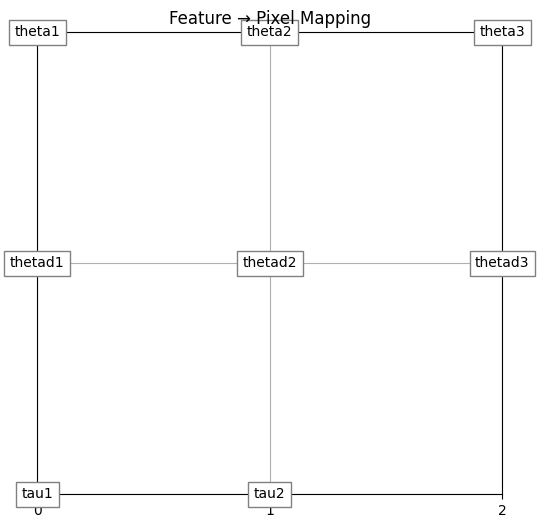

In [27]:
if hasattr(image_model, 'coordinate'):
    coordinates = image_model.coordinate
else:
    coordinates = (np.array([0, 0, 0, 1, 1, 1, 2, 2]),
                 np.array([0, 1, 2, 0, 1, 2, 0, 1]))

plot_feature_mapping(x_col, coordinates, scale=[3, 3])

In [28]:
# Combine dataloaders into tensors.
train_mlp, train_img, train_target = combine_loader(train_loader)
val_mlp, val_img, val_target = combine_loader(val_loader)
test_mlp, test_img, test_target = combine_loader(test_loader)

dataset = {
    "train_input": train_mlp.to(device),
    "train_img": train_img.to(device),
    "train_label": train_target.to(device),
    "val_input": val_mlp.to(device),
    "val_img": val_img.to(device),
    "val_label": val_target.to(device),
    "test_input": test_mlp.to(device),
    "test_img": test_img.to(device),
    "test_label": test_target.to(device),
}

In [32]:
# Print the shapes of the tensors
print("Train data shape:", dataset['train_input'].shape)
print("Train target shape:", dataset['train_label'].shape)
print("Test data shape:", dataset['test_input'].shape)
print("Test target shape:", dataset['test_label'].shape)
print("Validation data shape:", dataset['val_input'].shape)
print("Validation target shape:", dataset['val_label'].shape)

Train data shape: torch.Size([5242, 8])
Train target shape: torch.Size([5242, 1])
Test data shape: torch.Size([1639, 8])
Test target shape: torch.Size([1639, 1])
Validation data shape: torch.Size([1311, 8])
Validation target shape: torch.Size([1311, 1])


In [30]:
completed_coordinate, completed_x_col = complete_coordinate_and_xcol(coordinates, x_col)

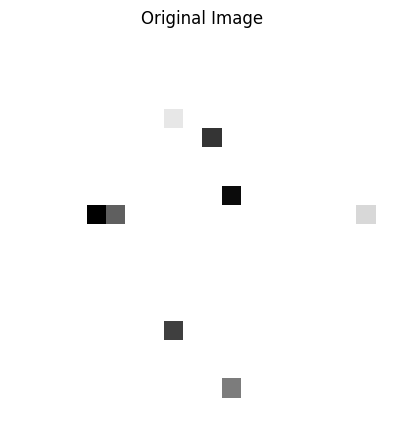

In [37]:
import matplotlib.pyplot as plt

def plot_original_image(img_input, x_col, coordinate, zoom=1, save_path=None, show=True):
    if img_input.dim() == 3:
        img_input = img_input.unsqueeze(0)

    img_disp = img_input.squeeze().detach().cpu()
    if img_disp.shape[0] == 1:
        img_disp = img_disp[0]
        #cmap = 'gray'
    else:
        img_disp = img_disp.permute(1, 2, 0)
        cmap = None

    h, w = img_disp.shape[:2]

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.imshow(img_disp, cmap=cmap)
    ax.set_title("Original Image")
    ax.axis('off')

    # for i, col in enumerate(x_col):
    #     abbrev = col.split("-")[0][:8]
    #     if i < len(coordinate[0]):
    #         r, c = coordinate[0][i], coordinate[1][i]
    #         ry = r * zoom + zoom // 2
    #         cx = c * zoom + zoom // 2
    #         if ry < h and cx < w:
    #             ax.text(cx, ry, abbrev,
    #                     color='white', fontsize=9, ha='center', va='center',
    #                     bbox=dict(facecolor='black', edgecolor='none', pad=1.0, alpha=0.4))

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    if show:
        plt.show()
    else:
        plt.close()

i=4
plot_original_image(dataset["test_img"][i], x_col, completed_coordinate, show=True)


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.09e+00 | val_loss: 3.12e+00 | reg: 3.06e+01 | : 100%|█| 40/40 [00:11<00:00,  3.62it/

saving model version 0.1
Best epoch: 32 
3.2279417514801025


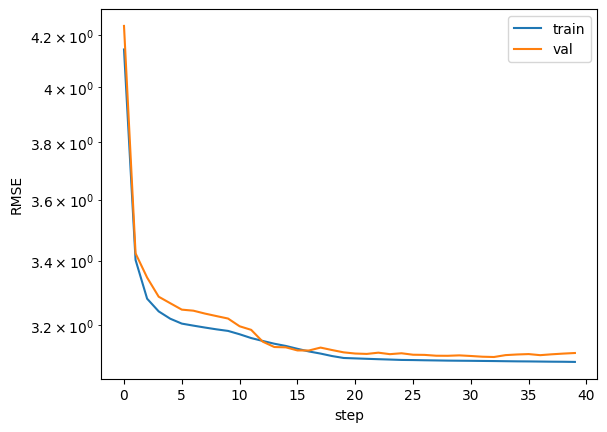

In [37]:
model = KAN(width=[attributes, 2, 1], grid=4, k=3, seed=381, device=device)
best_model_state, results, best_epoch  = custom_fit(model, dataset, opt="LBFGS", steps=40, lamb=1e-05)
model.load_state_dict(best_model_state)
plot_training_RMSE(average_rmse(model(dataset['test_input']), dataset['test_label']), results['train_loss'], results['val_loss'])

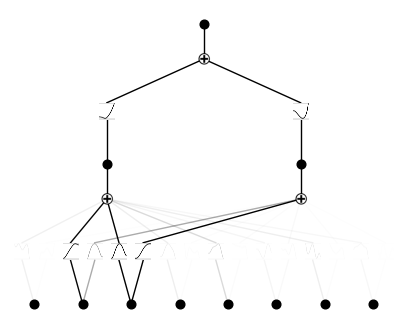

In [38]:
model.plot()

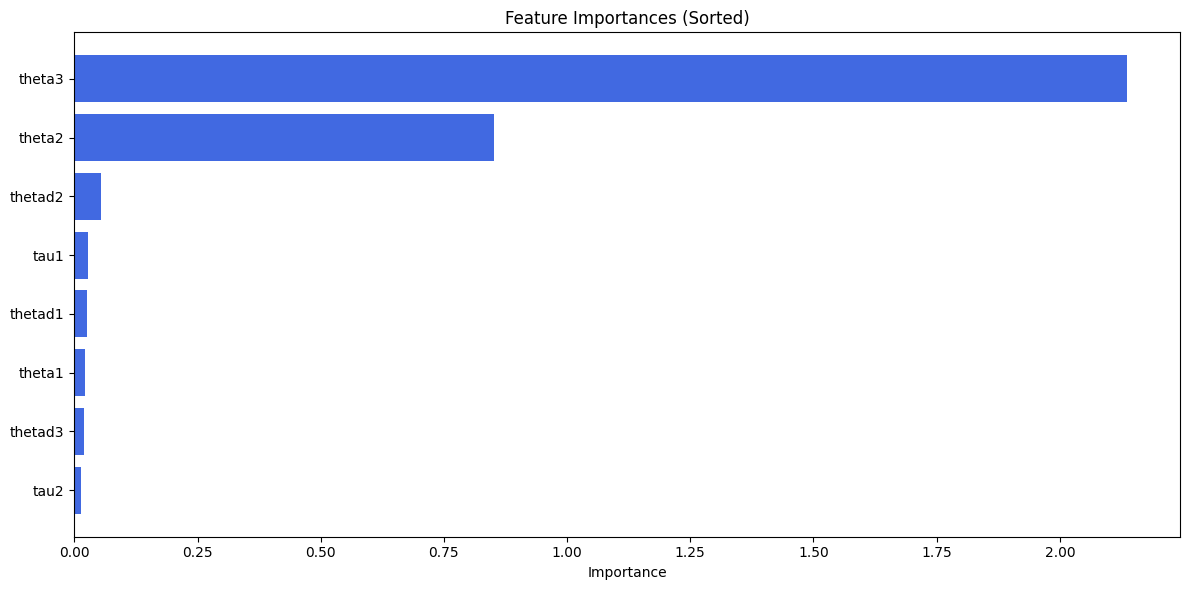

In [39]:
plot_sorted_feature_importance(x_col, model.feature_score)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.07e+00 | val_loss: 3.10e+00 | reg: 2.01e+01 | : 100%|█| 40/40 [00:11<00:00,  3.40it/

saving model version 0.1
Best epoch: 9 
3.229440927505493


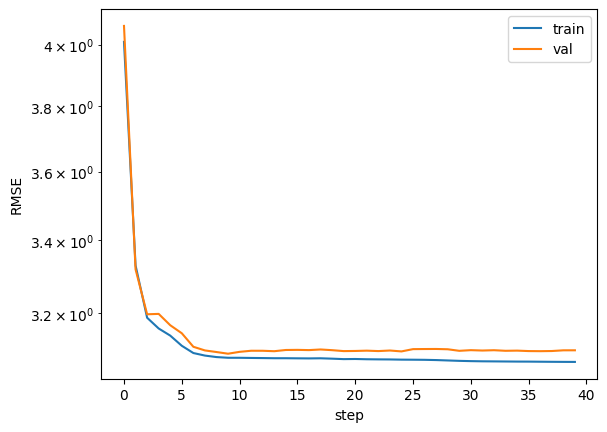

In [40]:
model = KAN(width=[attributes, 3, 1], grid=5, k=3, seed=381, device=device)
best_model_state, results, best_epoch  = custom_fit(model, dataset, opt="LBFGS", steps=40, lamb=0.01)
model.load_state_dict(best_model_state)
plot_training_RMSE(average_rmse(model(dataset['test_input']), dataset['test_label']), results['train_loss'], results['val_loss'])

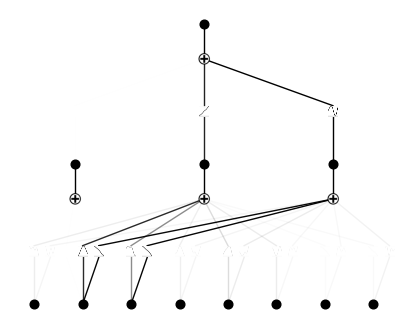

In [41]:
model.plot()

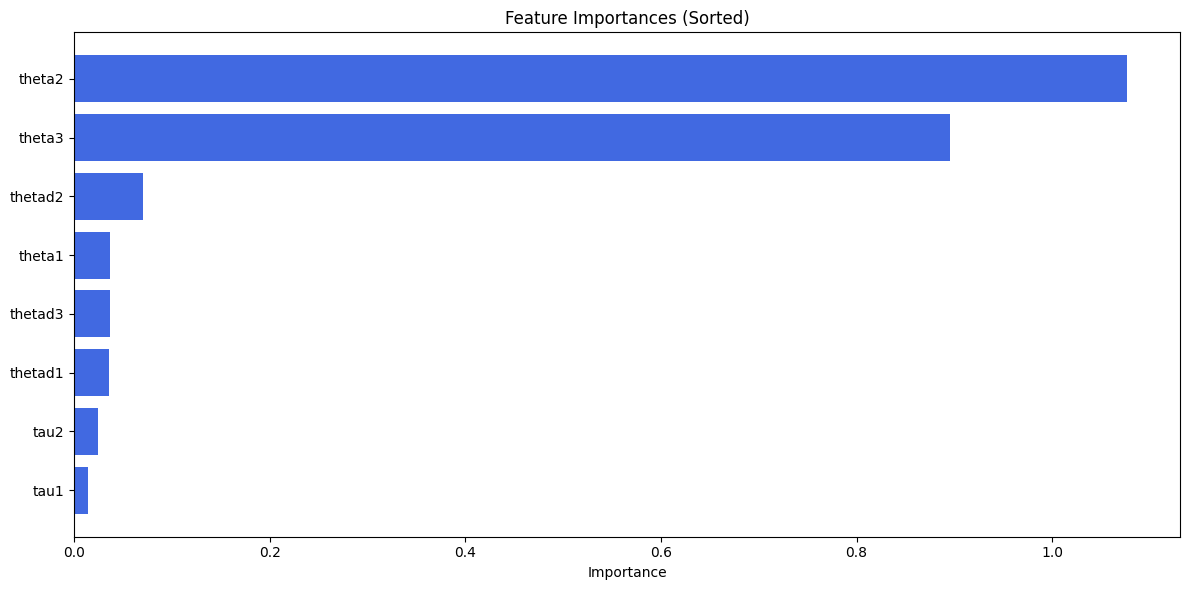

In [42]:
plot_sorted_feature_importance(x_col, model.feature_score)

# CNN training ✅ Top 2 Configurations

### 1. cnn_blocks=1, dense_layers=1 | best_epoch=18 | loss=3.22069

| Train: 8.9922e+00 | Val: 1.0137e+01 |: 100%|████████████████████| 100/100 [00:10<00:00,  9.10it/s]


✅ Best validation loss: 9.5093e+00 at 27 epoch
3.2374420166015625


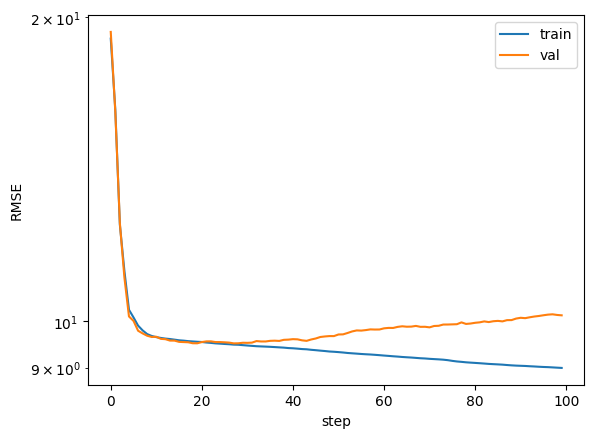

In [43]:
model = build_custom_cnn_model(cnn_blocks=1, dense_layers=1, imgs_shape=imgs_shape)
model_state, results, _ = fit_cnn_only_model(model, dataset, steps=100)
model.load_state_dict(model_state)
plot_training_RMSE(average_rmse(model(0, dataset['test_img']), dataset['test_label']), results['train_loss'], results['val_loss'])

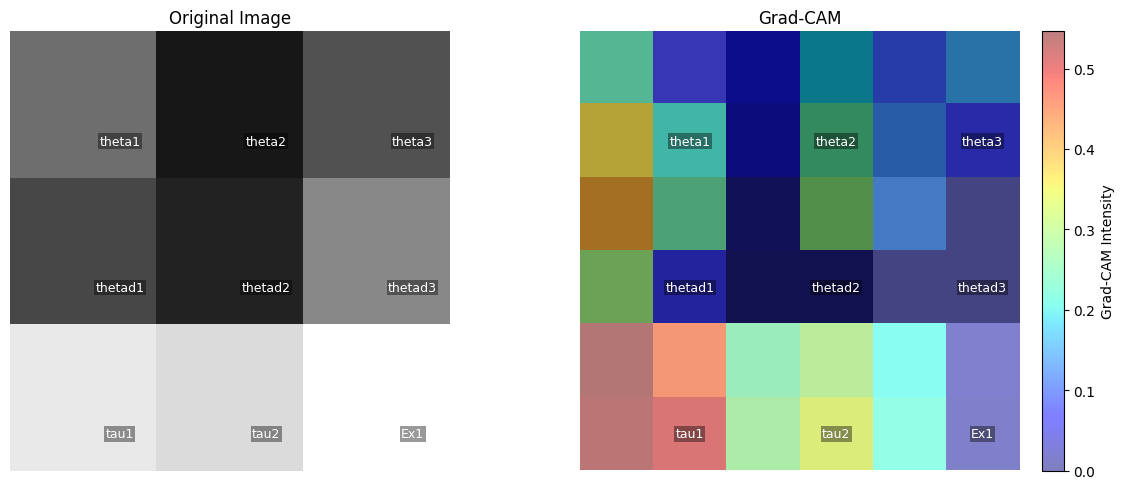

In [44]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=2
)

Computing Grad-CAM: 100%|██████████| 1639/1639 [01:34<00:00, 17.27it/s]


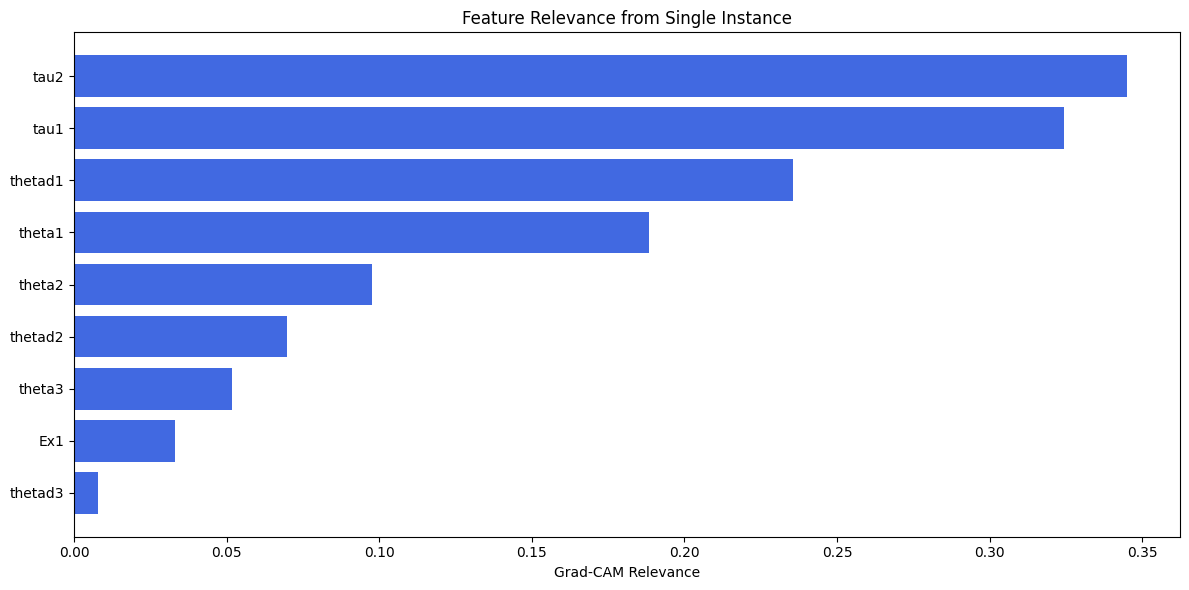

In [45]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=2
)
plot_feature_relevance_bar(avg_scores)

### 2. cnn_blocks=3, dense_layers=2 | best_epoch=4 | loss=3.24624

| Train: 2.4990e+00 | Val: 1.6989e+01 |: 100%|████████████████████| 110/110 [00:40<00:00,  2.74it/s]

✅ Best validation loss: 9.8336e+00 at 3 epoch
3.260375499725342


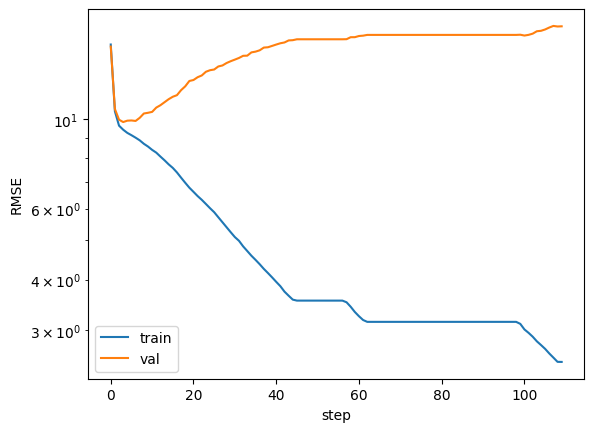

In [46]:
model = build_custom_cnn_model(cnn_blocks=3, dense_layers=2, imgs_shape=imgs_shape)
model_state, results, _ = fit_cnn_only_model(model, dataset, steps=110)
model.load_state_dict(model_state)
plot_training_RMSE(average_rmse(model(0, dataset['test_img']), dataset['test_label']), results['train_loss'], results['val_loss'])

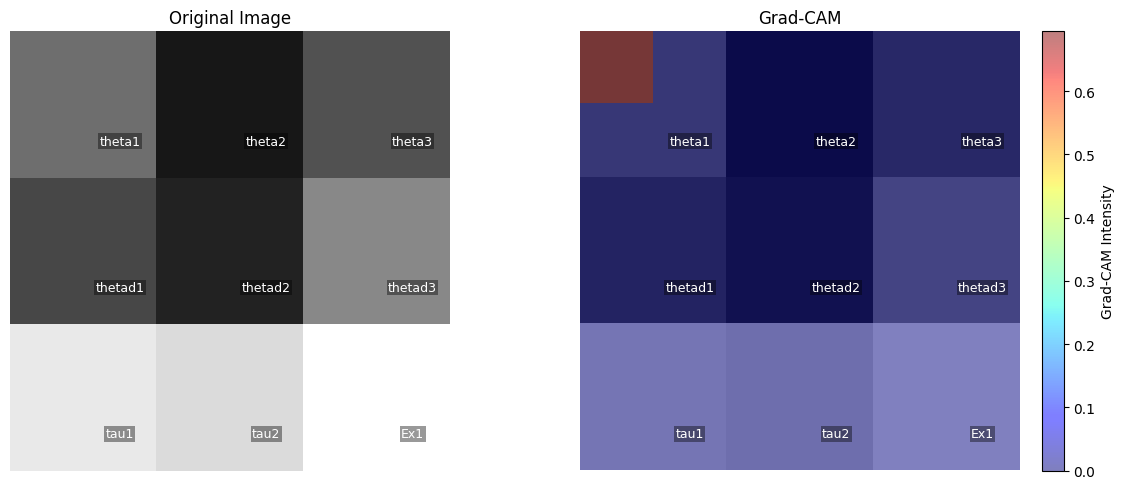

In [47]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=2
)

Computing Grad-CAM: 100%|██████████| 1639/1639 [01:44<00:00, 15.76it/s]


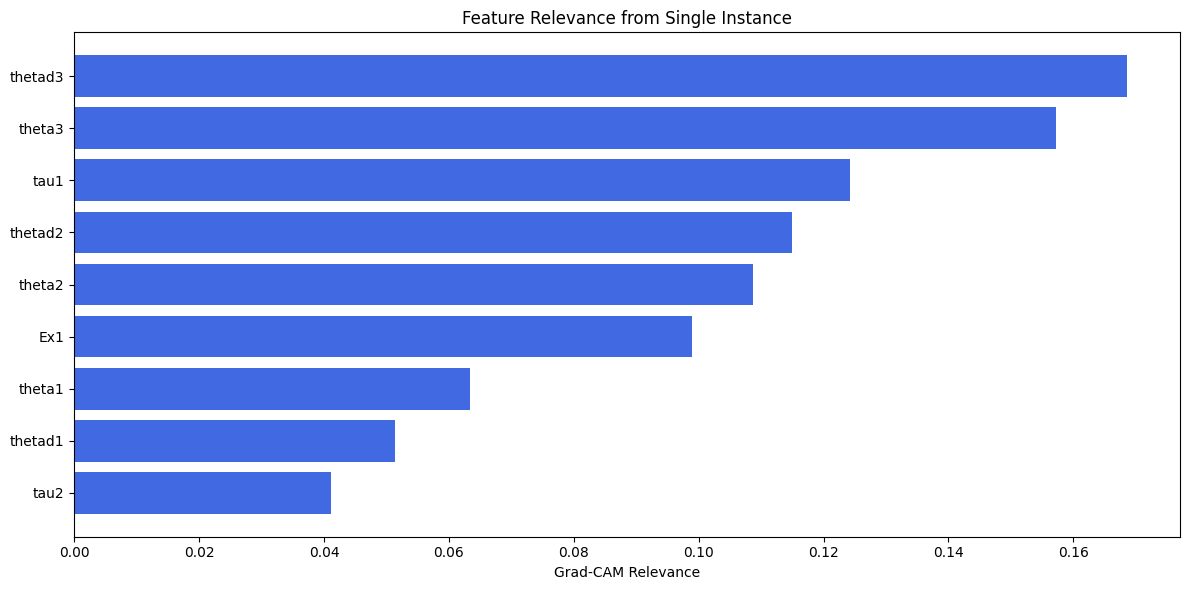

In [48]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=2
)
plot_feature_relevance_bar(avg_scores)

# Hibrid Model3 training ✅ Top 2 Configurations

### width=[8, 4, 1], grid=3, lamb=0.01| best_epoch=10 | loss=3.21696

In [ ]:
torch.cuda.empty_cache()
gc.collect()

In [34]:
model = try_create_model(Model3, attributes, imgs_shape, kan_neurons=4, kan_grid=3)
best_model_state, results,_ = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", steps=40, lamb=0.01)
model.load_state_dict(best_model_state)
plot_training_RMSE(average_rmse(model(dataset['test_input'], dataset['test_img']), dataset['test_label']), results['train_loss'], results['eval_loss'])

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


Training:   0%|                                                              | 0/40 [00:10<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.21 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 13.01 GiB is allocated by PyTorch, and 543.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

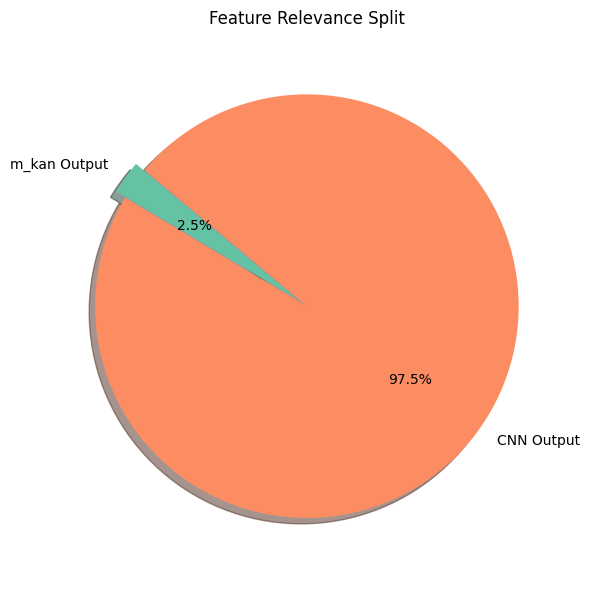

In [33]:
plot_mkan_vs_cnn_relevance(model.final_kan.feature_score, mkan_len=4)

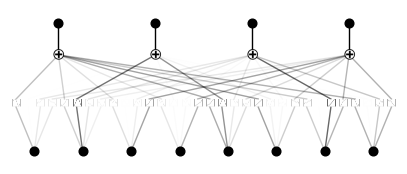

In [34]:
model.m_kan.plot()

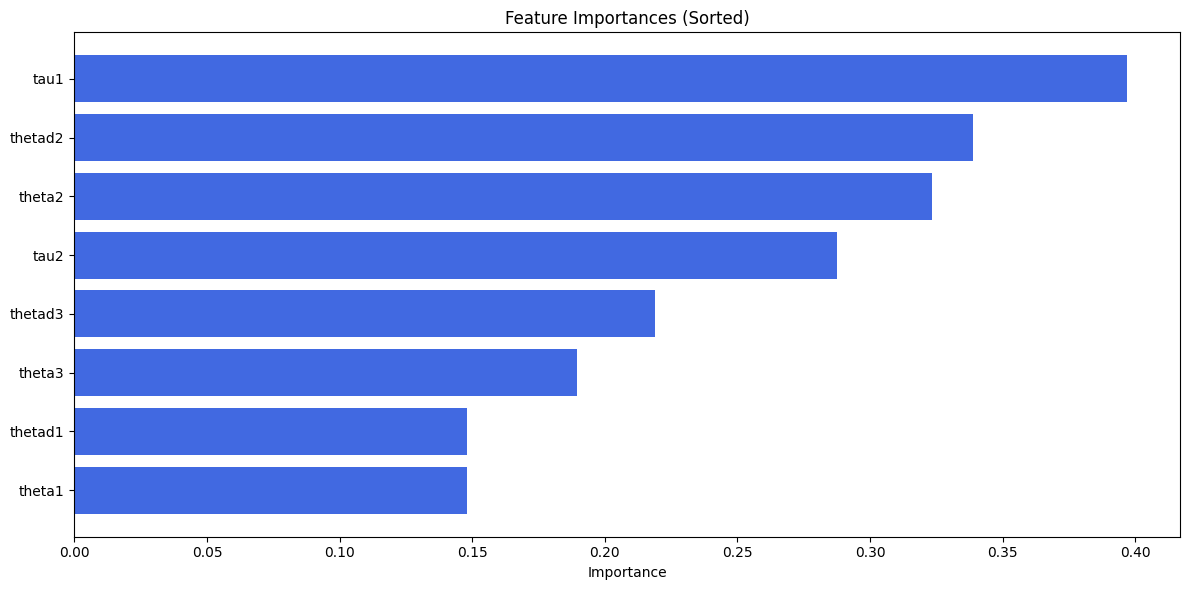

In [35]:
plot_sorted_feature_importance(x_col, model.m_kan.feature_score)

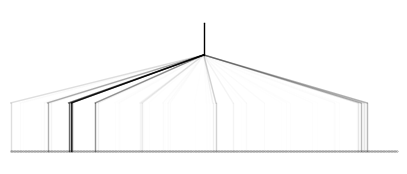

In [36]:
model.final_kan.plot()

C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by o

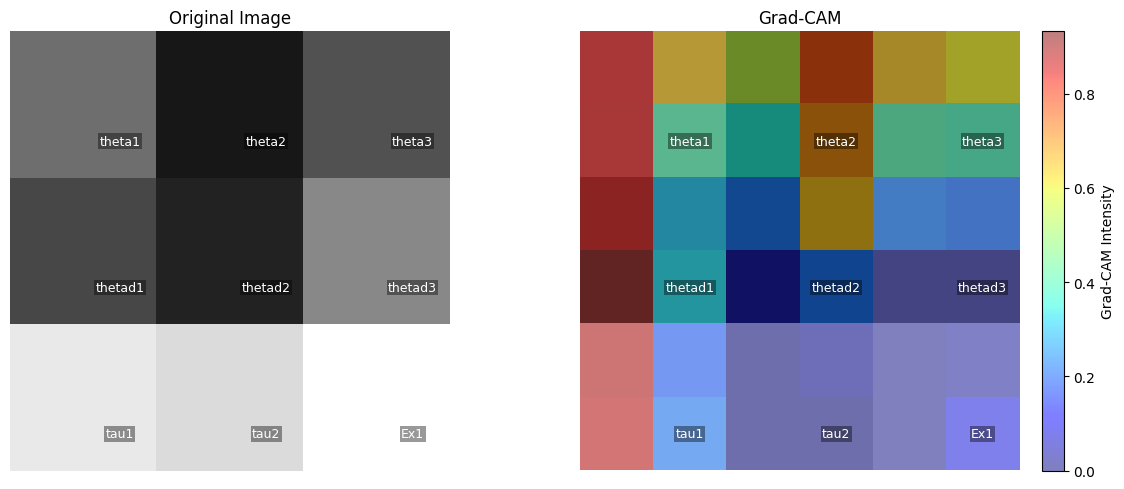

In [37]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=best_model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=2
)

Computing Grad-CAM: 100%|██████████| 1639/1639 [10:03<00:00,  2.72it/s] 


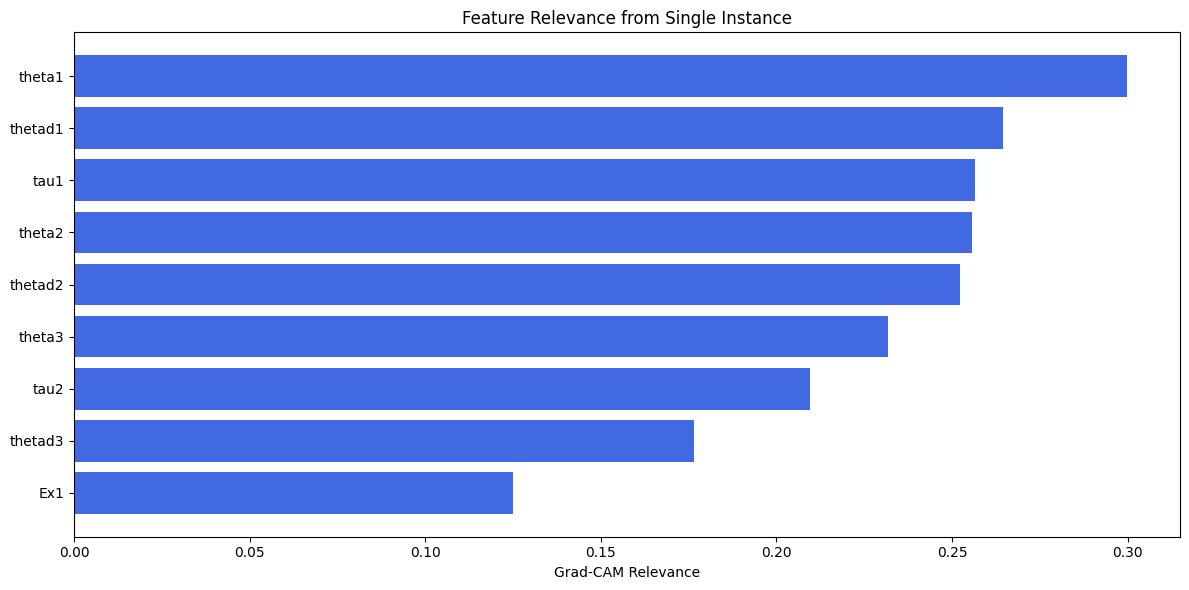

In [38]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=best_model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=2
)
plot_feature_relevance_bar(avg_scores)

### 2. width=[8, 3, 1], grid=5, lamb=0.01| best_epoch=12 | loss=3.21744

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 3.07e+00 | eval_loss: 3.20e+00 | reg: 6.58e+01 |: 100%|█| 40/40 [18:27<00:00, 27.68s/i


saving model version 0.1
Best epoch 10
3.234761953353882


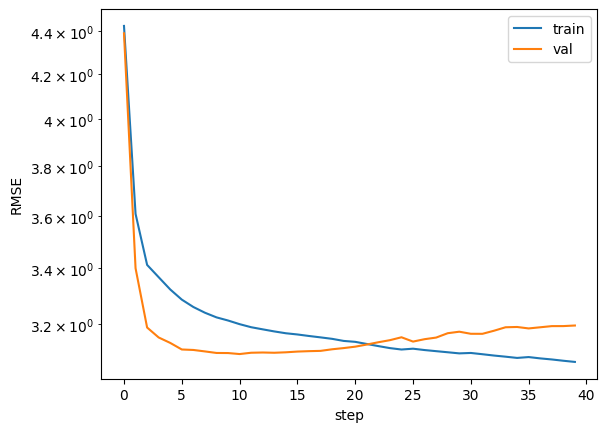

In [39]:
model = try_create_model(Model3, attributes, imgs_shape, kan_neurons=3, kan_grid=5)
best_model_state, results,_ = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", steps=40, lamb=0.01)
model.load_state_dict(best_model_state)
plot_training_RMSE(average_rmse(model(dataset['test_input'], dataset['test_img']), dataset['test_label']), results['train_loss'], results['eval_loss'])

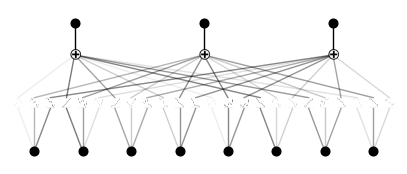

In [40]:
model.m_kan.plot()

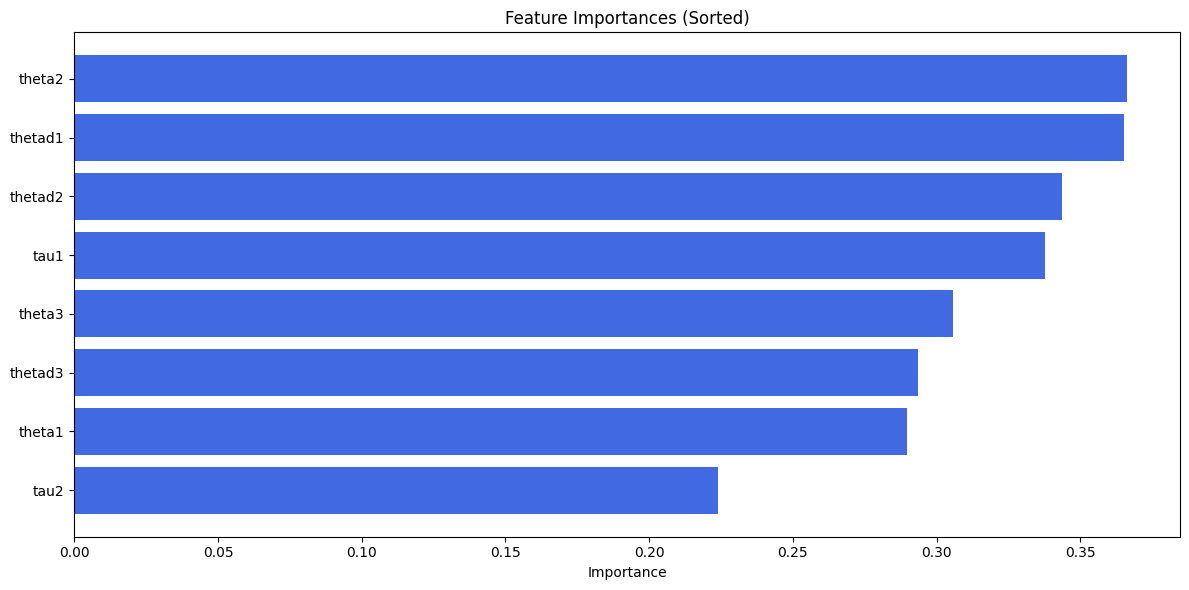

In [41]:
plot_sorted_feature_importance(x_col, model.m_kan.feature_score)

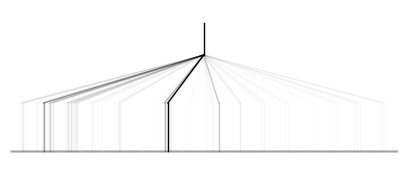

In [42]:
model.final_kan.plot()

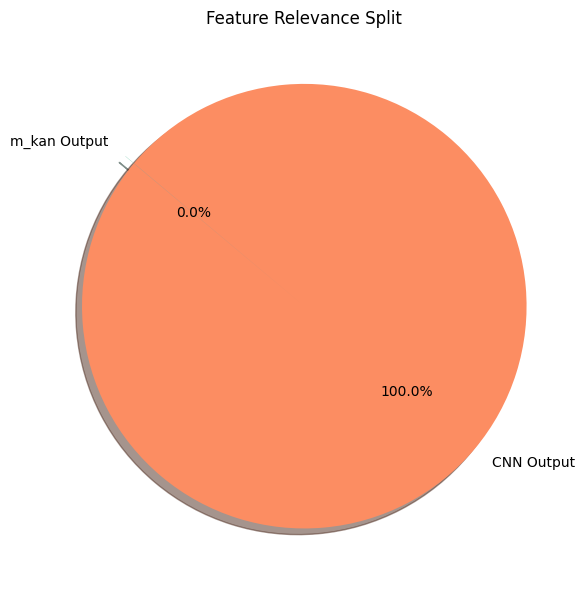

In [43]:
plot_mkan_vs_cnn_relevance(model.final_kan.feature_score, mkan_len=3)

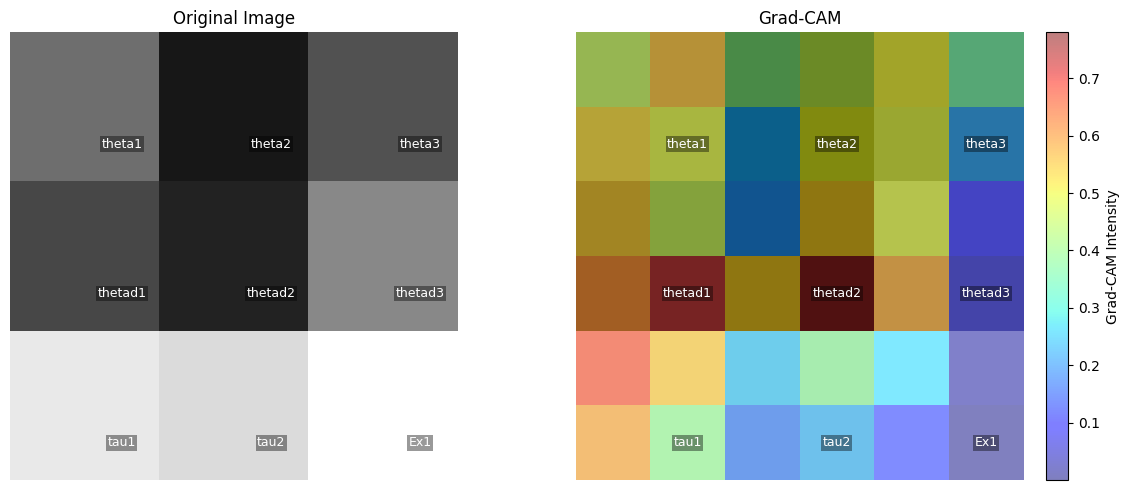

In [44]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=best_model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=2
)

Computing Grad-CAM: 100%|██████████| 1639/1639 [09:03<00:00,  3.02it/s]


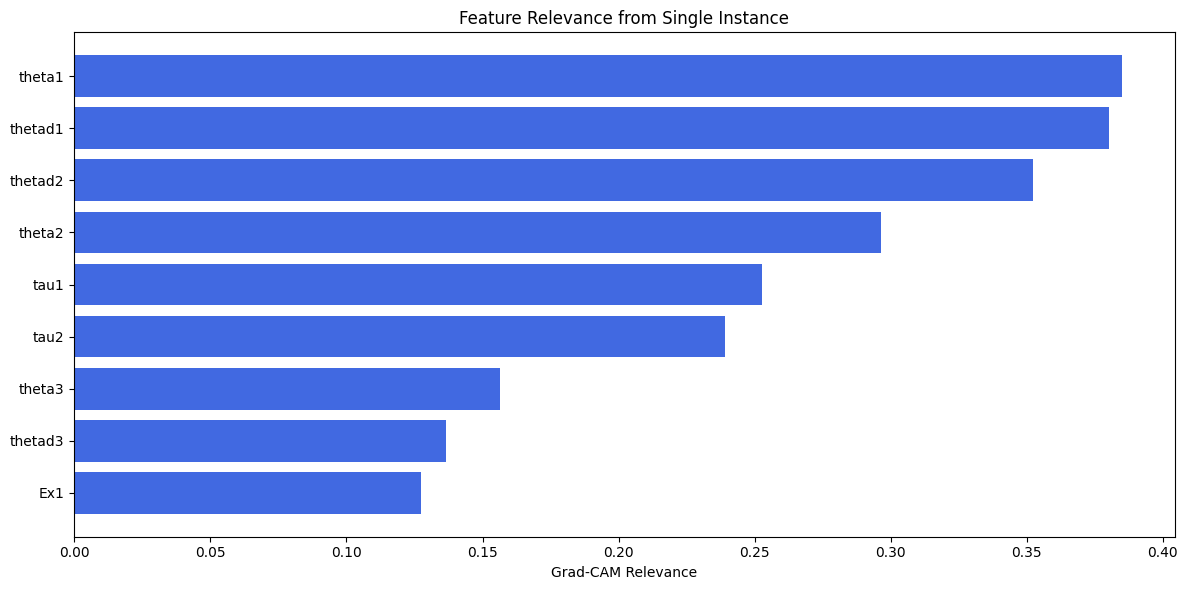

In [45]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=best_model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=2
)
plot_feature_relevance_bar(avg_scores)

# Hybrid Model4 training ✅ Top 2 Configurations

### 1. width=[8, 1, 1], grid=4, lamb=0.01| best_epoch=7 | loss=3.23119

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.81e+00 | eval_loss: 3.34e+00 | reg: 6.46e+01 |: 100%|█| 20/20 [01:44<00:00,  5.23s/i


saving model version 0.1
Best epoch 5
3.2293567657470703


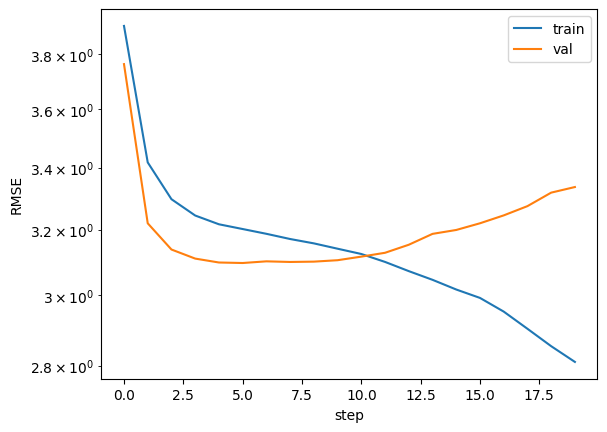

In [32]:
model = try_create_model(Model4, attributes, imgs_shape, kan_neurons=1, kan_grid=4)  # Attempt to create Model4
best_model_state, results, _ = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", steps=20, lamb=0.01)
model.load_state_dict(best_model_state)
plot_training_RMSE(average_rmse(model(dataset['test_input'], dataset['test_img']), dataset['test_label']), results['train_loss'], results['eval_loss'])

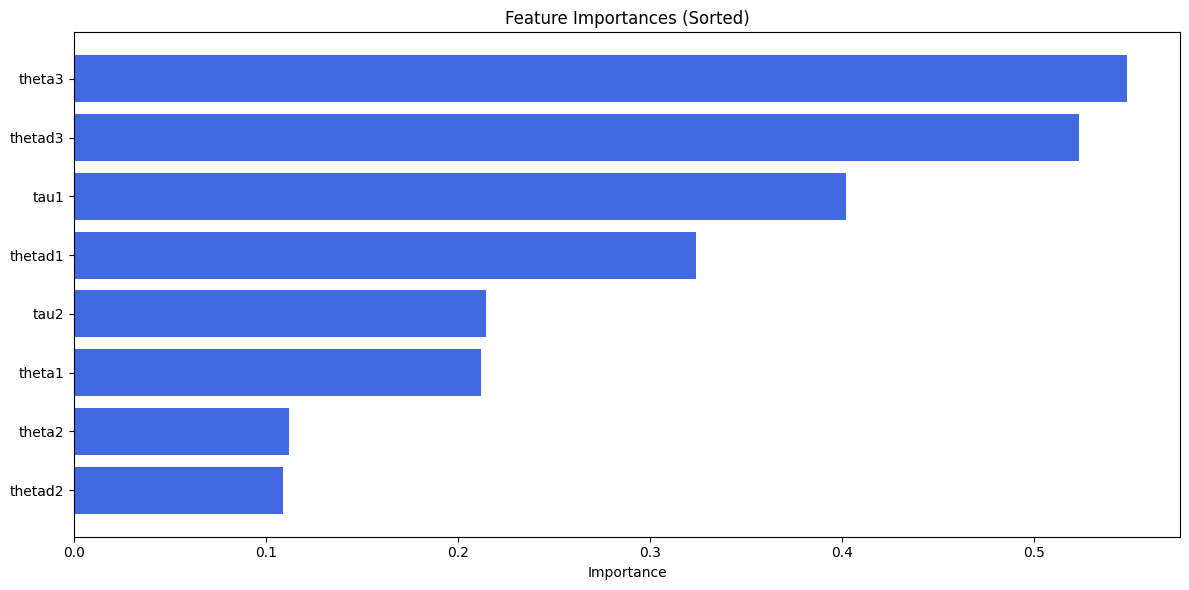

In [33]:
plot_sorted_feature_importance(x_col, model.m_kan.feature_score)

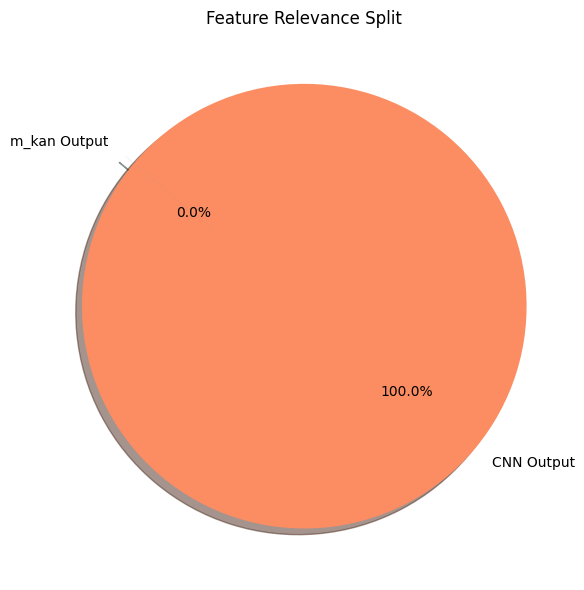

In [34]:
plot_mkan_vs_cnn_relevance(model.final_kan.feature_score, mkan_len=1)

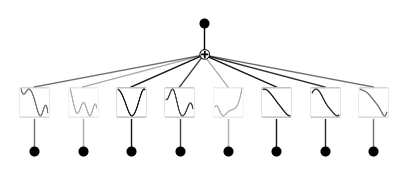

In [35]:
model.m_kan.plot()

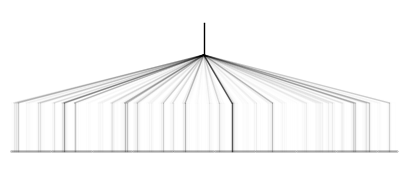

In [36]:
model.final_kan.plot()

C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:822: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:832: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
C:\Users\vgiov\OneDrive\Documents\Master Data Science\Thesis\pykan\kan\MultKAN.py:833: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by o

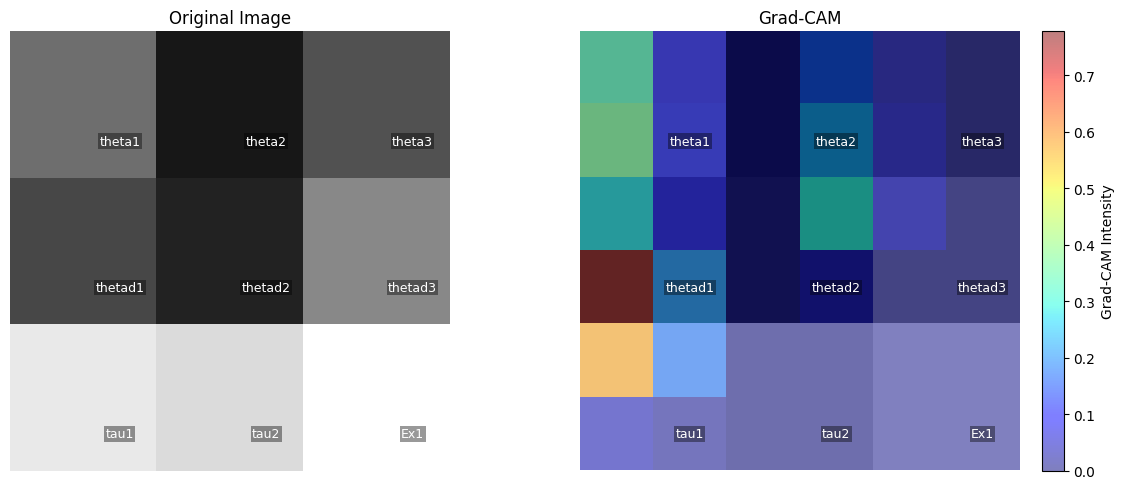

In [37]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=best_model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=2
)

Computing Grad-CAM: 100%|██████████| 1639/1639 [08:07<00:00,  3.36it/s]


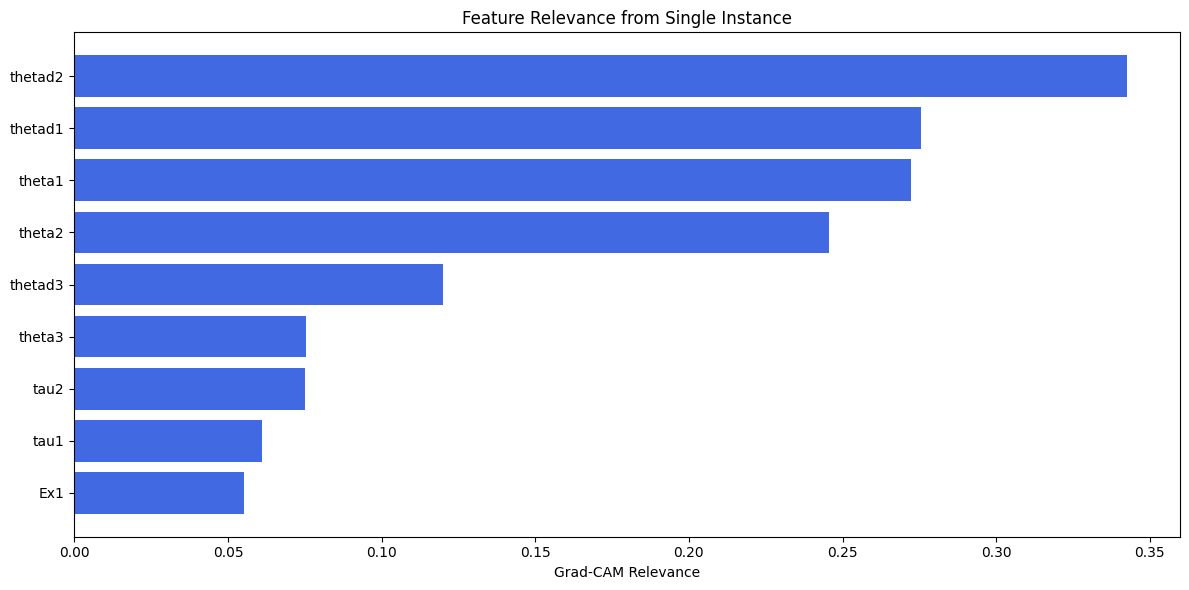

In [38]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=best_model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=2
)
plot_feature_relevance_bar(avg_scores)

### 2. width=[8, 2, 1], grid=4, lamb=0.1| best_epoch=7 | loss=3.23543

In [39]:
del model
torch.cuda.empty_cache()
gc.collect()

13313807

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 3.29e+00 | eval_loss: 3.20e+00 | reg: 2.23e+01 |: 100%|█| 40/40 [03:19<00:00,  4.99s/i


saving model version 0.1
Best epoch 12
3.242253303527832


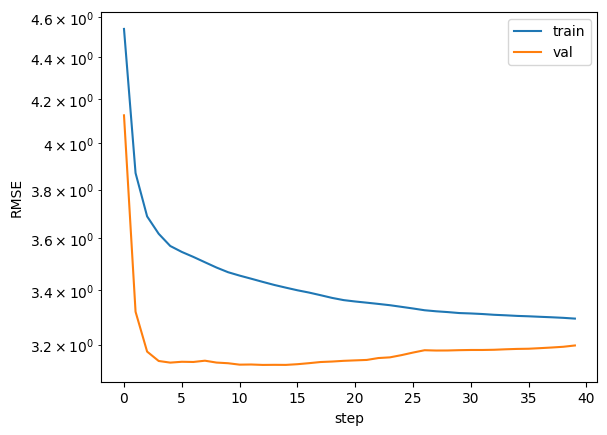

In [39]:
model = try_create_model(Model4, attributes, imgs_shape, kan_neurons=2, kan_grid=4)  # Attempt to create Model4
best_model_state, results, _ = fit_hybrid_dataloaders(model, dataset, opt="LBFGS", steps=40, lamb=0.1)
model.load_state_dict(best_model_state)
plot_training_RMSE(average_rmse(model(dataset['test_input'], dataset['test_img']), dataset['test_label']), results['train_loss'], results['eval_loss'])

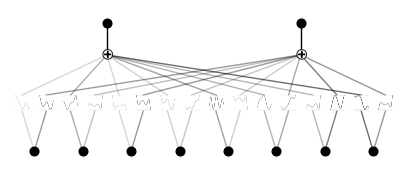

In [42]:
model.m_kan.plot()

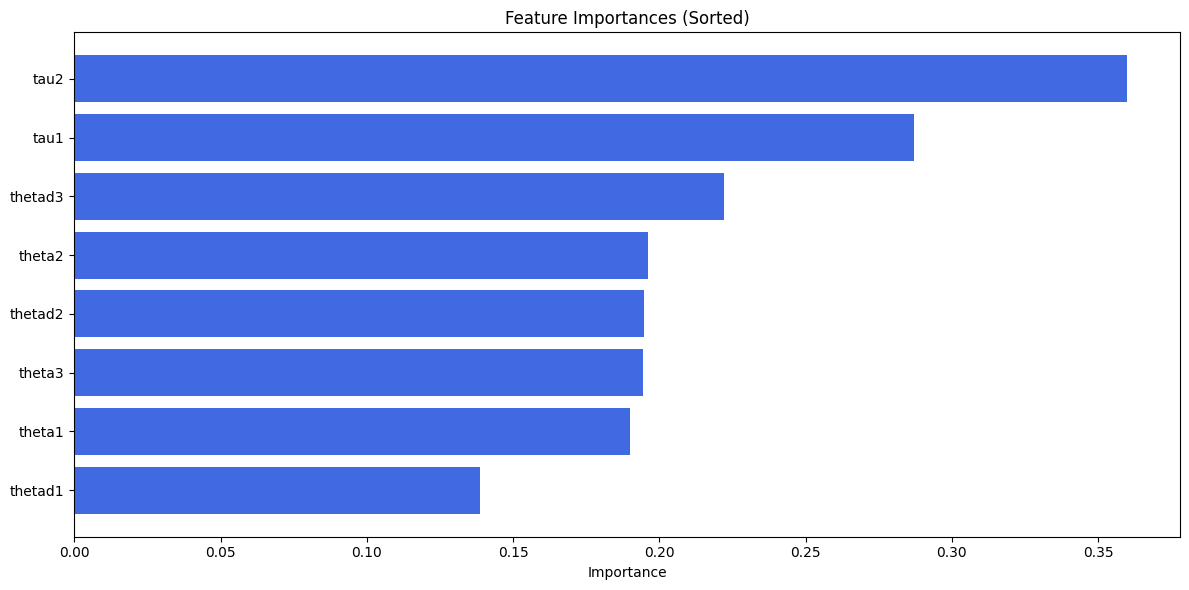

In [43]:
plot_sorted_feature_importance(x_col, model.m_kan.feature_score)

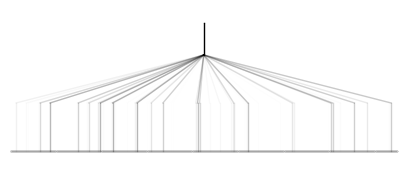

In [44]:
model.final_kan.plot()

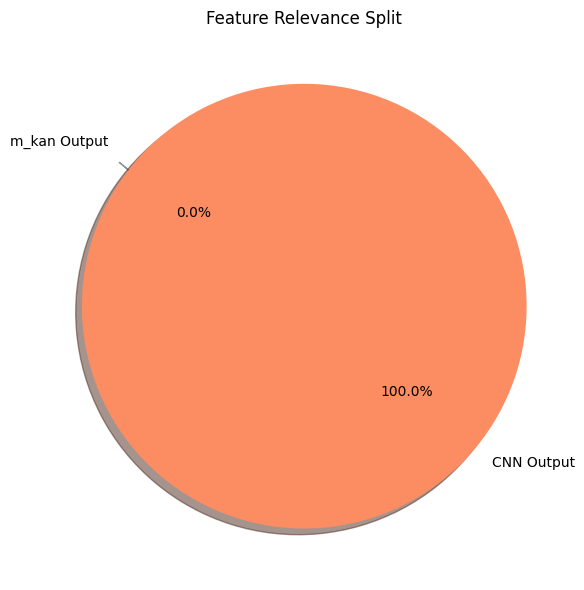

In [45]:
plot_mkan_vs_cnn_relevance(model.final_kan.feature_score, mkan_len=2)

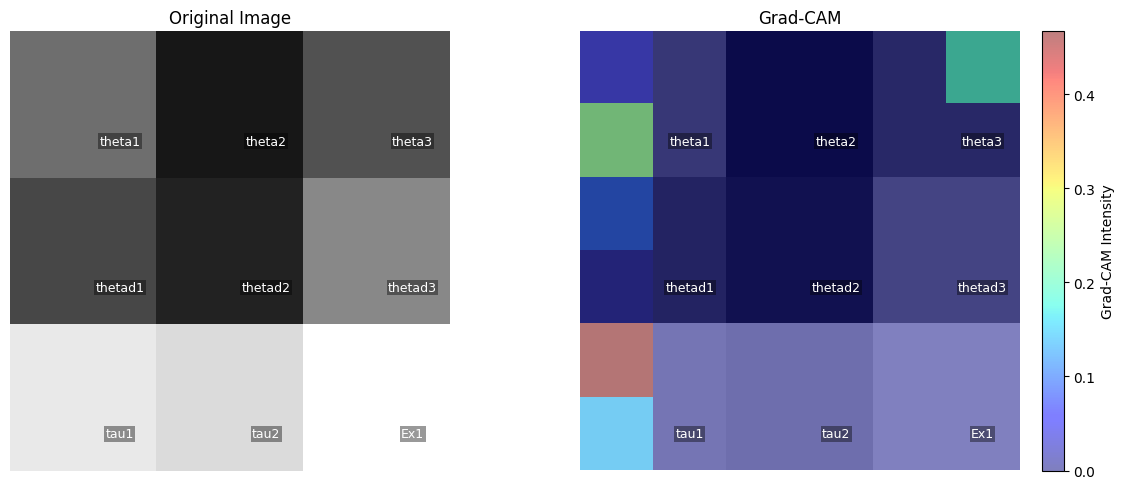

In [46]:
i = 4  # index of the image you want to explain
heatmap = grad_cam_side_by_side(
    model=model,
    model_state=best_model_state,
    num_input=dataset["test_input"][i],
    img_input=dataset["test_img"][i],
    x_col=completed_x_col,
    coordinate=completed_coordinate,
    zoom=2
)

Computing Grad-CAM: 100%|██████████| 1639/1639 [08:56<00:00,  3.05it/s]


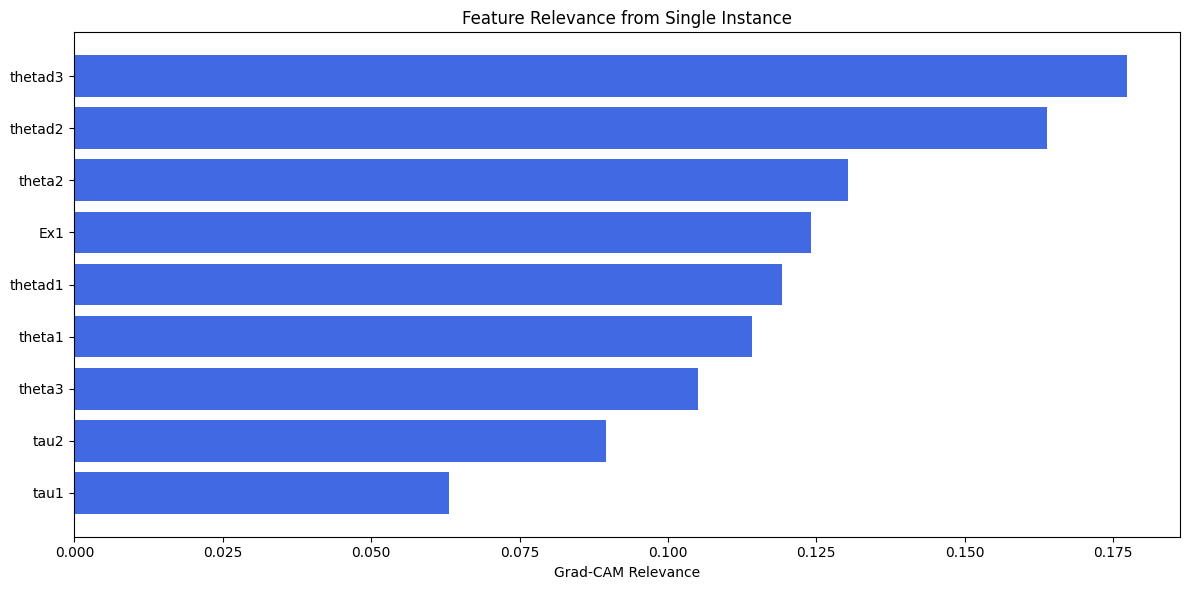

In [47]:
avg_scores = compute_avg_feature_relevance_from_val(
    model=model,
    model_state=best_model_state,
    val_inputs=dataset["test_input"],
    val_imgs=dataset["test_img"],
    coordinate=completed_coordinate,
    x_col=completed_x_col,
    zoom=2
)
plot_feature_relevance_bar(avg_scores)